# Analysis of unbalanced datasets with Weights & Biases
_**Performance metrics for unbalanced datasets for a binary classification task**_

---

## Contents

1. [Summary](#Summary)
1. [Preparation](#Preparation)
    1. [Data Loading](#Data_Loading)
1. [Preprocessing](#Preprocessing)
    1. [Exploratory Data Analysis](#Exploratory_Data_Analysis)
    1. [Feature enginering & selection](#Feature_enginering_&_selection)
1. [Training](#Training)
    1. [Random Forest](#Random_Forest)
    1. [Logistic Regression](#Logistic_Regression)
    1. [XGBoost](#XGBoost)
1. [Metrics](#Metrics)
1. [Testing](#Testing)
1. [Conclusion](#Conclusion)

---

# Summary
[Back to Contents](#Contents)

This notebook analyzes the performance of classic machine learning algorithms for binary classification. It uses a dataset of questionaries collected via phone calls, and whether a customer subscribes to a bank deposit. Thus, the prediciton of bank deposits relies on information like demographics, past interactions, and environmental factors. The models are *supervised* because we train the model with a portion of the dataset (i.e., training dataset). When using a supervised learning technique we may enconter that using an unbalanced dataset - a dataset containing - may have effects on the model performance (like accuracy, etc.).

After selecting the most significant features, we will test some of the most famous machine learning algorithms used for classification, like Logistic Regression, RandomForest and XGBoost classifiers. We monitor the efficacy of every model when using balanced and unbalanced datasets for training and log everything in [Weights and Biases](https://wandb.ai)

---

# Preparation
[Back to Contents](#Contents)

This notebook requires a basic understanding of class inheritance in Python. It shows examples of 1) custom Transformers for data enginering, 2) statistical testing for feature selection, and 3) training common supervised models for a binary classification task. 

It requires familiarity with:
* Standard scientific modules for data handling (pandas),
* Modules for scientific analysis (Scipy, NumPy and machine learning Scikit-learn)
* The scientific library for data visualization (matplotlib).

It also assumes that basic machine learning methods, like test/train split and hyperparameter searching. It is otherwise possible to follow the notebook with a minimal background.


STATISTICAL TESTING FOR FEATURE SELECTION IS STILL UNDERCONSTRUCTION
ToDo:
* statisical feature selection
* Add SCV and XBoost models
* Add more metrics to Summary in wandb

In [1]:
# data handling
import pandas as pd

# numerical analysis
import numpy as np

# OS-independent path
from pathlib import Path   

# data visualization (See Preprocessing -> Exploration)
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.style.use('https://raw.githubusercontent.com/JoseGuzman/minibrain/master/minibrain/paper.mplstyle') # minibrain plotting

# other (e.g. for python >=3.6 type definitions like age: int = 1)
from typing import List, Tuple

## Data_Loading
[Back to Contents](#Contents)

We will use a [Bank Marketing Dataset](https://www.kaggle.com/datasets/joseguzman/bank-additional) that contains 41,118 customers replies to 21 questions. There's also a smaller dataset with 10% of the samples selected ramdonly that we will use to validate our pipeline and test different parameters and the efficacy of different supervised learning methods. I also prepared a 10% dataset balanced (i.e., 50% yes/no) to the outcome of the questions.

In [2]:
%ls ../input/bank-marketing # see available files

bank-additional-balanced.csv  bank-additional-names.txt
bank-additional-full.csv      bank-additional.csv


In [3]:
# Preparation:load datasets

train_file = '../input/bank-marketing/bank-additional.csv' # training dataset
train = pd.read_csv(train_file)

print('The train dataset contains {0} entries and {1} features'.format(*train.shape))

test_file =  '../input/bank-marketing/bank-additional-full.csv' # test dataset
test = pd.read_csv(test_file)

print('The test dataset contains {0} entries and {1} features'.format(*test.shape))

# preview train data
train.head()

The train dataset contains 4118 entries and 21 features
The test dataset contains 41188 entries and 21 features


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [4]:
# convert target to integers (0, )
train_target = (train.y == 'yes').astype(int) # pd.Series .to_numpy()
test_target = (test.y == 'yes').astype(int) #.to_numpy()

We reduce memory of the data set with the description [here](https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65/notebook)

In [34]:
def reduce_mem_usage(df:pd.DataFrame, verbose:bool = False) -> pd.DataFrame:
    """ 
    Reduce size of a pandas DataFrame object by reducing data types 
    in columns.
    See here: https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65/notebook    
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    if verbose:
        msg = 'Dataset reduced from {:.2f} '.format(start_mem)
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    
    if verbose:
        percentage = 100 * (start_mem - end_mem)/start_mem
        msg += 'to {0:.2f} MB ({1:2.2f}%)'.format(end_mem, percentage)
        print(msg)
    
    return df

We summarize everything in a custom funtion to load csv files in Pandas 

In [16]:
def data_loader(file:str, verbose:bool = False) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Loads csv file and return a tuple with a pandas dataset 
    containing all features, and a pandas Series with the 
    target variable.
    """
    
    data = pd.read_csv(file)
    df = reduce_mem_usage(df = data, verbose = verbose)
    target = (data.y == 'yes').astype(int)
    
    if verbose:
        print('The dataset contains {0} entries and {1} features'.format(*data.shape))
    
    return data, target

In [36]:
# being redundant here with filenames

test_file =  '../input/bank-marketing/bank-additional-full.csv' # test dataset
train_file = '../input/bank-marketing/bank-additional.csv' # unbalanced training dataset

test, test_target  = data_loader(test_file, verbose=True)
train, train_target = data_loader(train_file)

Dataframe reduced from 6.60 to 1.10 MB (83.30%)
The dataset contains 41188 entries and 21 features


# Preprocessing
[Back to Contents](#Contents)

We first need to become familiar with features and datatypes.

### File information 

1. **bank-additional-full.csv** with all examples, ordered by date (from May 2008 to November 2010).
2. **bank-additional.csv** with 10% of the examples, randomly selected from *bank-additional-full.csv*.
3. **bank-additional-balanced.txt** 10% of the entries with 50% of succesfull bank subscriptions (i.e., balanced) 

<HR>

### Column descriptors

#### 1. Demographics:

- age: Customer's age (numeric)
- job: Type of job (categorical: 'admin.', 'services', ...)
- marital: Marital status (categorical: 'married', 'single', ...)
- education: Level of education (categorical: 'basic.4y', 'high.school', ...)

#### 2. Past customer events:

- default: Has credit in default? (categorical: 'no', 'unknown', 'yes')
- housing: Has housing loan? (categorical: 'no', 'yes', 'unknown')
- loan: Has personal loan? (categorical: 'no', 'yes', 'unknown')


#### 3. Past direct marketing contacts:

- contact: Contact communication type (categorical: 'cellular', 'telephone', ...)
- month: Last contact month of year (categorical: 'may', 'nov', ...)
- day_of_week: Last contact day of the week (categorical: 'mon', 'fri', ...)
- duration: Last contact duration, in seconds (numeric). Important note: If duration = 0 then y = 'no'.

#### 4. Campaign information:

- campaign: Number of contacts performed during this campaign and for this client (numeric, includes the last contact)
- pdays: Number of days that passed by after the client was last contacted from a previous campaign (numeric)
- previous: Number of contacts performed before this campaign and for this client (numeric)
- poutcome: Outcome of the previous marketing campaign (categorical: 'nonexistent',''success, ...)


#### 5. Socioeconomic factors:

- emp.var.rate: Employment variation rate - quarterly indicator (numeric)
- cons.price.idx: Consumer price index - monthly indicator (numeric)
- cons.conf.idx: Consumer confidence index - monthly indicator (numeric)
- euribor3m: Euribor 3 month rate - daily indicator (numeric)
- nr.employed: Number of employees - quarterly indicator (numeric)

<HR>

### Target variable:

The dataset can be used to train a classifier to predict if a client will subscribe (yes/no) to a bank term deposit. Thus, y is whether the client subscribed to a term deposit (binary: 'yes', 'no')



### Exploratory_Data_Analysis

[Back to Contents](#Contents)

We will familiarize with basic metrics, like the number of observations and features collected in the dataset. Also, the empirical distributions of the independent variables (i.e., features) and the depedent variable will be important to build a model with generalization.    


In [37]:
# Exploration: obtain a basic description of categories and types 
train.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4118 entries, 0 to 4117
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             4118 non-null   int8    
 1   job             4118 non-null   category
 2   marital         4118 non-null   category
 3   education       4118 non-null   category
 4   default         4118 non-null   category
 5   housing         4118 non-null   category
 6   loan            4118 non-null   category
 7   contact         4118 non-null   category
 8   month           4118 non-null   category
 9   day_of_week     4118 non-null   category
 10  duration        4118 non-null   int16   
 11  campaign        4118 non-null   int8    
 12  pdays           4118 non-null   int16   
 13  previous        4118 non-null   int8    
 14  poutcome        4118 non-null   category
 15  emp.var.rate    4118 non-null   float16 
 16  cons.price.idx  4118 non-null   float16 
 17  cons.conf.idx 

and check if there are missing values

In [38]:
# Exploration: check for missing values in both train and test datasets
test.isnull().values.any(), train.isnull().values.any() # 

(False, False)

We become familiar with the dataset when obtain a graphic visual representation of the categories and its relation with the indepedent variable. It is called [Exploratory Data Analysis](https://en.wikipedia.org/wiki/Exploratory_data_analysis) (EDA). The first step is always to see the distribution of the independent variable (in our case 'y')

In [39]:
# Exploration: evaluate if data is uniformly distributed
train.y.value_counts() # data is umbalanced!

no     3667
yes     451
Name: y, dtype: int64

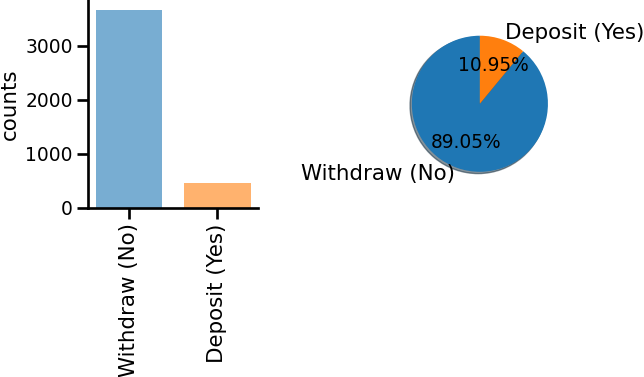

In [40]:
# Exploration: visualization of target variable

credit = train['y'].value_counts() 

fig, ax = plt.subplots(1,2, figsize =(6,3))
fig.tight_layout(pad = 1, h_pad = 2, w_pad = 4)

mylabels = ['Withdraw (No)', 'Deposit (Yes)']
mycolors = ['tab:blue', 'tab:orange']

ax[0].bar(x=mylabels, height = credit, color = mycolors, width = 0.75, alpha = .6)

for tick in ax[0].get_xticklabels():
    tick.set_rotation(90)
ax[0].set_ylabel('counts')#, ax[0].set_yticks(np.arange(0,4000,500))

ax[1].pie(credit.values, labels = mylabels, colors = mycolors, autopct='%2.2f%%',shadow=True, startangle=90);

The first observation is that the data is umbalanced (i.e., the target variable has different proportions in both test and training datasets). 
We therefore load a balanced test dataset to find out what are the relevant variables to determine the independent variable (i.e., target)

In [41]:
train, train_target = data_loader(file = '../input/bank-marketing/bank-additional-balanced.csv')

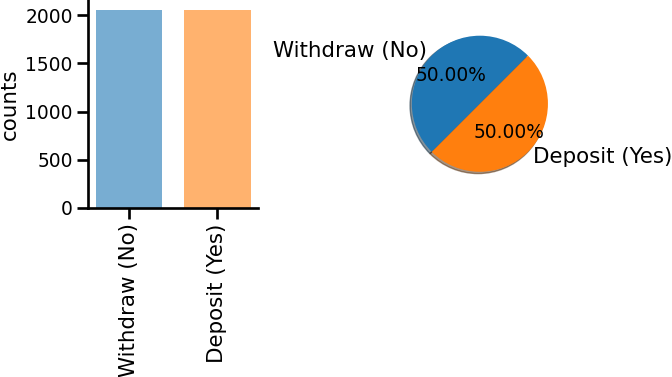

In [42]:
# Exploration: visualization of target variable

credit = train['y'].value_counts() 

fig, ax = plt.subplots(1,2, figsize =(6,3))
fig.tight_layout(pad = 1, h_pad = 2, w_pad = 4)

mylabels = ['Withdraw (No)', 'Deposit (Yes)']
mycolors = ['tab:blue', 'tab:orange']

ax[0].bar(x=mylabels, height = credit, color = mycolors, width = 0.75, alpha = .6)

for tick in ax[0].get_xticklabels():
    tick.set_rotation(90)
ax[0].set_ylabel('counts')#, ax[0].set_yticks(np.arange(0,4000,500))

ax[1].pie(credit.values, labels = mylabels, colors = mycolors, autopct='%2.2f%%',shadow=True, startangle=45);

In [43]:
# Exploration: descriptive statistics of numerical variables
train.describe() # basis statistics for numerical variables

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,4118.00000,4118.000000,4118.000000,4118.000000,4118.000000,4118.000000,4118.00000,4118.000000,4118.000000,4118.0000
mean,40.35017,383.201797,2.307188,888.314230,0.316659,-0.505371,inf,-inf,2.945312,inf
std,11.96551,358.455961,2.256688,312.552613,0.698567,1.711914,0.62793,5.328125,1.886719,86.9375
min,17.00000,4.000000,1.000000,0.000000,0.000000,-3.400391,92.18750,-50.812500,0.633789,4964.0000
25%,31.00000,143.000000,1.000000,999.000000,0.000000,-1.799805,92.87500,-42.687500,1.244141,5076.0000
50%,38.00000,260.000000,2.000000,999.000000,0.000000,-1.099609,93.43750,-41.812500,1.798828,5100.0000
75%,48.00000,522.000000,3.000000,999.000000,0.000000,1.400391,94.00000,-36.406250,4.957031,5228.0000
max,98.00000,3631.000000,32.000000,999.000000,6.000000,1.400391,94.75000,-26.906250,5.046875,5228.0000


When analyzing numerical variables in relationship to the independent variable - in our case the subscription to a bank account - we may start seeing
some dependencies.

In [44]:
# Exploration: see average values upon deposit
mydf = train.groupby('y').mean()
mydf

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,,
no,39.754735,215.017970,2.572122,984.06168,0.136960,0.200562,93.5625,-40.62500,3.761719,5176.0
yes,40.945605,551.385624,2.042254,792.56678,0.496357,-1.211914,93.3750,-39.90625,2.128906,5096.0


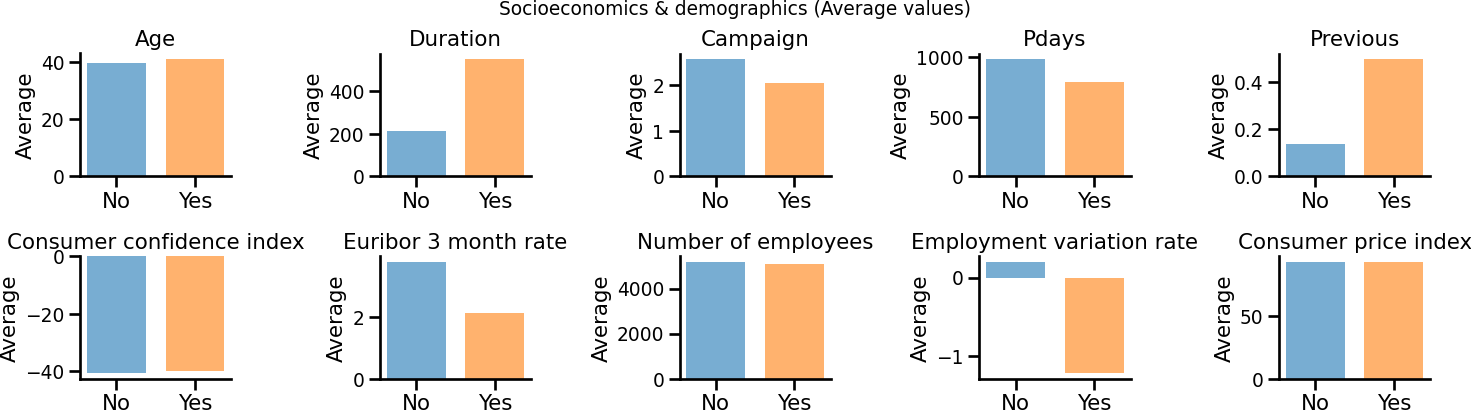

In [45]:
# Exploration: plot average of numeric variables

fig, ax = plt.subplots(2, 5, figsize = (16,5))
fig.tight_layout(pad = 3, h_pad = 2, w_pad = 4)
fig.suptitle('Socioeconomics & demographics (Average values)', fontsize=14)
mylabels = ['No', 'Yes']
mycolors = ['tab:blue', 'tab:orange']
myparams = dict(width=0.75, alpha =0.6, color = mycolors)

ax[0,0].bar(x=mylabels, height = mydf.age, **myparams)
ax[0,0].set_title('Age')

ax[0,1].bar(x=mylabels, height = mydf.duration, **myparams)
ax[0,1].set_title('Duration')

ax[0,2].bar(x=mylabels, height = mydf.campaign, **myparams)
ax[0,2].set_title('Campaign')

ax[0,3].bar(x=mylabels, height = mydf.pdays, **myparams)
ax[0,3].set_title('Pdays')

ax[0,4].bar(x=mylabels, height = mydf.previous, **myparams)
ax[0,4].set_title('Previous')

ax[1,0].bar(x=mylabels, height = mydf['cons.conf.idx'], **myparams)
ax[1,0].set_title('Consumer confidence index')

ax[1,1].bar(x=mylabels, height = mydf.euribor3m, **myparams)
ax[1,1].set_title('Euribor 3 month rate')

ax[1,2].bar(x=mylabels, height = mydf['nr.employed'], **myparams)
ax[1,2].set_title('Number of employees')

ax[1,3].bar(x=mylabels, height = mydf['emp.var.rate'], **myparams)
ax[1,3].set_title('Employment variation rate')

ax[1,4].bar(x=mylabels, height = mydf['cons.price.idx'], **myparams)
ax[1,4].set_title('Consumer price index')

for myax in ax.flatten():
    myax.set_ylabel('Average')

Variables like employment variation rate (**emp.var.rate**)or Euribor (**euribor3m**) have different proportions, whereas other - for example **age**-
have similar proportions of acceptance and rejection of a bank subscription.

We also realize that some numerical variables are either not relevant or must be reacomodated. For example, in **pday** (number of days from previous campaign) the value 999 means client was not previously contacted. Other variables are problematic (e.g., **duration**). The duration of a call cannot be directly controlled in advance, or we don't want to account it for the model, because is a variable that has to do with the way we performed the interview, and not the values obtained from the sample.

Finally, to study the distributions of relevant variables for the outcome, we plot the histograms. If possible, I tend here to plot here the whole - test- dataset, or proportion of it (train, 10% in our case). If we use the umbalanced train dataset, we can normalize the distributions with the argument *(density = True)* when ploting.

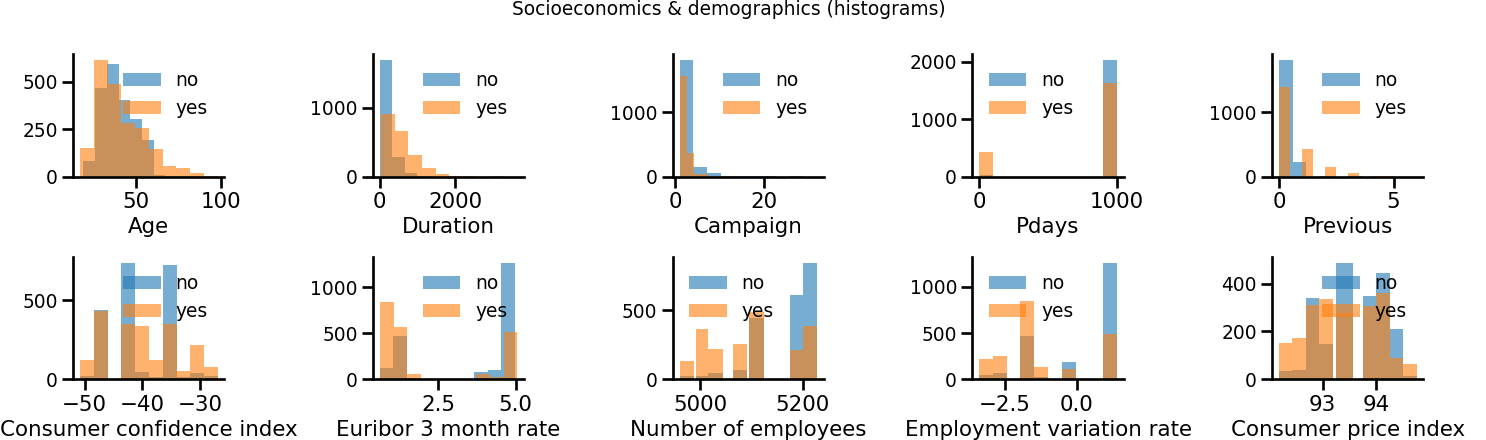

In [46]:
mydf = train.groupby('y')
fig, ax = plt.subplots(2, 5, figsize = (16,5))
fig.tight_layout(pad = 3, h_pad = 2, w_pad = 4)
fig.suptitle('Socioeconomics & demographics (histograms)', fontsize=14)
fig.legend(loc=1)
# use true if umbalanced dataset
myparams = dict(density = False, alpha = 0.6, stacked = True, legend = True, grid = False) 

ax[0,0].set_xlabel('Age')
mydf.age.hist(ax = ax[0,0], **myparams);

ax[0,1].set_xlabel('Duration')
mydf.duration.hist(ax = ax[0,1], **myparams);

ax[0,2].set_xlabel('Campaign')
mydf.campaign.hist(**myparams, ax = ax[0,2]);

ax[0,3].set_xlabel('Pdays')
mydf.pdays.hist(**myparams, ax = ax[0,3]);

ax[0,4].set_xlabel('Previous')
mydf.previous.hist(**myparams, ax = ax[0,4]);

ax[1,0].set_xlabel('Consumer confidence index')
mydf['cons.conf.idx'].hist(**myparams, ax = ax[1,0]);

ax[1,1].set_xlabel('Euribor 3 month rate')
mydf.euribor3m.hist(**myparams, ax = ax[1,1]);

ax[1,2].set_xlabel('Number of employees')
mydf['nr.employed'].hist(**myparams, ax = ax[1,2]);

ax[1,3].set_xlabel('Employment variation rate')
mydf['emp.var.rate'].hist(**myparams, ax = ax[1,3]);

ax[1,4].set_xlabel('Consumer price index')
mydf['cons.price.idx'].hist(**myparams, ax = ax[1,4]);


* We remove **duration**

In [47]:
# Exploration: duration of a call cannot be directly controlled,and if value is zero the subscription is 'no' 
train.drop(['duration'], axis=1)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,48,technician,married,professional.course,yes,no,no,cellular,aug,tue,1,999,0,nonexistent,1.400391,93.4375,-36.09375,4.964844,5228.0,no
1,42,admin.,married,high.school,no,no,no,cellular,nov,mon,2,999,1,failure,-0.099976,93.1875,-42.00000,4.191406,5196.0,yes
2,71,admin.,married,basic.4y,no,yes,yes,cellular,may,fri,4,3,2,success,-1.799805,93.8750,-40.00000,0.684082,5008.0,yes
3,39,blue-collar,married,basic.9y,no,yes,no,telephone,oct,fri,1,999,0,nonexistent,-0.099976,93.8125,-40.40625,4.917969,5196.0,yes
4,67,retired,married,professional.course,no,no,no,telephone,oct,mon,2,999,0,nonexistent,-3.400391,92.4375,-26.90625,0.738770,5016.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4113,37,services,divorced,basic.6y,no,no,no,cellular,nov,thu,2,999,0,nonexistent,-0.099976,93.1875,-42.00000,4.074219,5196.0,no
4114,45,admin.,married,university.degree,no,no,no,cellular,jul,thu,1,999,0,nonexistent,-2.900391,92.5000,-33.59375,1.072266,5076.0,yes
4115,60,retired,married,high.school,no,no,no,cellular,sep,wed,1,999,0,nonexistent,-1.099609,94.1875,-37.50000,0.875977,4964.0,yes
4116,49,blue-collar,married,high.school,unknown,yes,no,cellular,nov,mon,1,999,0,nonexistent,-0.099976,93.1875,-42.00000,4.191406,5196.0,no


* We adapt the variable **pday** to replace 999 by -1 and add a new variable **previous_contact**

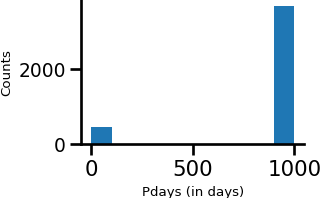

In [48]:
# Exploration: in pday (number of days from previous campaign) 999 means client was not previously contacted

ax = train.pdays.hist(figsize=(3,2))
ax.set_ylabel('Counts', fontsize=10);
ax.set_xlabel("Pdays (in days)",fontsize=10);
ax.grid(False)

In [49]:
# Exploration: pdays contains 3659 values (containing the number 999). 
train.pdays.value_counts()

999    3659
3       148
6       129
4        28
7        21
2        19
13       17
5        15
12       15
9        13
10       12
15        8
11        8
14        5
1         4
0         4
16        4
18        2
8         2
26        1
21        1
17        1
22        1
25        1
Name: pdays, dtype: int64

In [50]:
# Exploration: reate a new column and substitute 999 by -1
train['previous_contact'] = (train['pdays'] != 999).astype(int) # transform bool in int here
train.previous_contact.value_counts()

0    3659
1     459
Name: previous_contact, dtype: int64

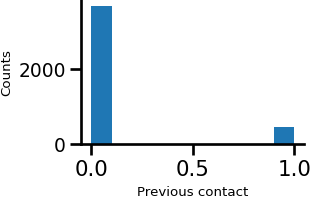

In [51]:
# Exploration
ax = train.previous_contact.hist(figsize=(3,2)); # most of them were not previoulsy contacted (0)
ax.set_ylabel('Counts', fontsize = 10)
ax.set_xlabel('Previous contact', fontsize = 10)
ax.grid(False)

In [52]:
train.loc[train["previous_contact"]==False, "pdays"] = -1 # if not contact, days -1


In [53]:
train.pdays.value_counts() # now we have -1 and not 999

-1     3659
 3      148
 6      129
 4       28
 7       21
 2       19
 13      17
 5       15
 12      15
 9       13
 10      12
 15       8
 11       8
 14       5
 1        4
 0        4
 16       4
 18       2
 8        2
 26       1
 21       1
 17       1
 22       1
 25       1
Name: pdays, dtype: int64



## Feature_enginering_&_selection
[Back to Contents](#Contents)

Feature ingeniering is a routinary task than includes custom cleanup or adaptation of features in our dataset to be processed by our machine learning algorithm. We will perform feature ingeniering with custom transformers, because we will concatente them [scikit-learn Pipeline object](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). Having organized pipelines is useful to optimize parameters and for testing how different data enginering strategies the performance of our models. We will process the dataset to account for the following

<HR>
    
* Load into DataFrame object, and change the value . into _ (**PandasTransformer**)
* Eliminate non-relevant features (**DropperTransformer**)
* Create new features like 'unemployed' and adapt (**FeaturesTransformer**)
* Standarise numeric values to mean = 0 and standard deviation =1 (**CustomStandardScaler**)
* Normalise numeric variables to min = 0 and max = 1 (**CustomMinMaxScaler**)
* Transform category variables (**CustomOneHotEncoder**)



In [54]:
# Transformation: load libraries for Transformer creation
from sklearn.base import BaseEstimator, TransformerMixin

_Custom transformers inherit from the [TransformerMixin class](https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html) to obtain the fit_transform() method. We also get get_params() and set_params() when inherinting from the [BaseEstimator class](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html)._

The first transformer will create directly a Pandas object and perform some regular expression operations. The rest of the transformers will operate on a pandas DataFrame objects.

In [55]:
# Transformation
# This transformer can be loaded with a csv_file at construction 
# >> mypandas = PandasTrasformer(regex = [], csv_file = 'file.csv')), or 
# or after creation of object 
# myfile = {'csv_file': '../input/bank-additional/bank-additional/bank-additional.csv'}
# >>>mypandas.set_params(**myfile)
# or when executing transformation
# >>> mypandas.transform(csv_file = 'file.csv')

class PandasTransformer(BaseEstimator, TransformerMixin):
    """
    To load the data into a Dataframe and transform its content
    according to a regular expression substitution.

    Usage
    -----
    >>> myregex = RegexTransformer(regex = [(r'\_','.')])
    >>> df = myregex.transform(csv_file = 'data.csv')

    """

    def __init__(self, regex:List[Tuple] = None, csv_file:str = None) -> None:
        """
        Select which dataframe will be used to load pandas
        DataFrame, and replace content with . into _
        
        Parameter
        ---------
        regex: list
            a list of regular expression substitutions 
            (e.g., [(r'\.','_'),(r'\_)]).
        
        csv_file: str
            The path to a DataFrame object.
        """
        self.regex = regex # for set_params() and get_params()
        self.csv_file = csv_file # for set_params() and get_params()

        
    def fit(self, X, y = None):
        """
        Nothing to do here
        """
        return self
   
    def transform(self, csv_file:str = None) -> pd.DataFrame:
        """
        Returns a pandas DataFrame with substituted
        regular expression (with . into _)
        
        Parameter
        ---------
        csv_file: str
            The path to a DataFrame object.
            
        Returns
        -------
        A Panda DataFrame with regular expressions altered
        """
        if csv_file is not None:          
            self.csv_file = csv_file
            
        df = pd.read_csv(self.csv_file)
        
        if self.regex is not None: # defined at construction
            for exp, val in self.regex:
                # Change the value . into _ and blanck _     
                df.replace(to_replace = exp, value = val, regex=True, inplace = True)
                # Eliminate _ if at the end of value (eg. admin. -> admin_ -> admin)            
                df.replace(to_replace = val+'$', value = '', regex=True, inplace = True) 

        return df 

* We test **PandasTransformer**

In [56]:
# Transformation: check we don't have '.' but '_'
myfile = '../input/bank-marketing/bank-additional.csv'
myregex = PandasTransformer(regex = [(r'\.','_')])

mydf = myregex.transform(csv_file = myfile)
mydf.education.unique(), train.education.unique()

(array(['basic_9y', 'high_school', 'university_degree',
        'professional_course', 'basic_6y', 'basic_4y', 'unknown',
        'illiterate'], dtype=object),
 ['professional.course', 'high.school', 'basic.4y', 'basic.9y', 'university.degree', 'unknown', 'basic.6y', 'illiterate']
 Categories (8, object): ['basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown'])

In [57]:
# Transformation: Dropper instructions here
class DropperTransformer(BaseEstimator, TransformerMixin):


    def __init__(self, features:List[str]) -> None:
        """
        Select which extesion will be used to load pandas
        Dataframes (by default *.df).
        
        Parameter
        ---------
        dataframe:  a pandas DataFrame object 
        """

        self.features = features


    def fit(self, X:np.array, y = None):
        """
        Nothing to do here
        """
        return self
   
    def transform(self, X:pd.DataFrame = None) -> pd.DataFrame:
        """
        Returns a pandas DataFrame with removed features.
        
        Parameter
        ---------
        dataframe:  Pandas DataFrame object
        """
        df = X.copy()
        
        # Drop features
        return  df.drop(self.features, axis = 1)
        

* We test the **DropperTransformer**

In [58]:
# Transformation: check we remove columns
mydropper = DropperTransformer( features = ['age', 'duration', 'cons.price.idx']) 
test.columns, mydropper.transform(test).columns

(Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
        'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
        'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
        'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
       dtype='object'),
 Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
        'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome',
        'emp.var.rate', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
       dtype='object'))

In [59]:
# Transformation 
# custom transformer to remove 999 value and include 
# new variables (previous_contact, unemployed)
class FeaturesTransformer(TransformerMixin):
    """ Hard-cored dataset"""

    def __init__(self) -> None:
        """
        Nothing to do here
        """
       
    def fit(self, X:pd.DataFrame, y = None):
        """
        Nothing to do here
        """
        return self
   
    def transform(self, X:pd.DataFrame = None) -> pd.DataFrame:
        """
        Returns a pandas DataFrame with new features
        (previous_contact and unemployed).
        
        Parameter
        ---------
        pd.dataframe:  Pandas DataFrame object
        """
        df = X.copy()
        
        # create 'previous_contact'
        df['previous_contact'] = (df['pdays'] != 999).astype(int) 
        df.loc[df["previous_contact"]==False, "pdays"] = -1 # if not contact, days -1
        
        # create 'unemployed'
        df["unemployed"] = df["job"].isin(["student", "retired", "unemployed"]).astype(int) # int for better OHE
        
        return df
        
        

* Test **FeaturesTransformer**

In [60]:
# Transformation: check column transformer
myfeature = FeaturesTransformer()
test.columns, myfeature.transform(X = test).columns, 


(Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
        'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
        'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
        'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
       dtype='object'),
 Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
        'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
        'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
        'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'previous_contact',
        'unemployed'],
       dtype='object'))

In [61]:
# Transformer: check this 
# https://blog.telsemeyer.com/2019/12/15/writing-your-own-sklearn-transformer-dataframes-feature-scaling-columntransformer-writing-your-own-sklearn-functions-part-two/
class CustomStandardScaler(BaseEstimator, TransformerMixin):
    """
    Custom Transformer to accomodate DataFrames to StandardScaler
    """
    def __init__(self, features: List[str]) -> None:
        
        self.features = features
        
        self.means_ = None
        self.stds_ = None
       

    def fit(self, X: pd.DataFrame, y: pd.Series = None):
        
        # create a dictionary with features and average values
        self.means_ = {col: np.mean(X[col]) for col in self.features}
        self.stds_ = {col: np.std(X[col]) for col in self.features}
    
        return self
    

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Returns a pandas DataFrame with all features
        normalized to mean = 0, and standard deviation =1
        
        Parameter
        ---------
        pd.dataframe:  Pandas DataFrame object
        """
        df = X.copy()
        
        self.means_ = {col: np.mean(df[col]) for col in self.features}
        self.stds_ = {col: np.std(df[col]) for col in self.features}
        
        for col in self.features:
            df[col] = (df[col] - self.means_[col]) / self.stds_[col]
        
        return df

In [62]:
# Transformation: test our new scaler has standar deviation 1
myz_score = CustomStandardScaler(['age','emp.var.rate'])
mystd = myz_score.transform(test).age.std() # must be 1.00


# Assert returned value is 1.0000 (four floating precission)
precission = 4
#abs(desired-actual) < 0.5 * 10**(-precission)
abs(1-mystd) < 0.5 * 10**(-precission)

True

In [63]:
# Transformer: check this 
# https://blog.telsemeyer.com/2019/12/15/writing-your-own-sklearn-transformer-dataframes-feature-scaling-columntransformer-writing-your-own-sklearn-functions-part-two/
class CustomMinMaxScaler(BaseEstimator, TransformerMixin):
    """
    Custom Transformer to accomodate DataFrames to StandardScaler
    """
    def __init__(self, features: List[str]) -> None:
        
        self.features = features
        
        self.min_, self.max_ = 1, 0
       
    def fit(self, X:pd.DataFrame, y = None):
        """
        Nothing to do here
        """
        return self
    

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Returns a pandas DataFrame with all features
        normalized to max = 0, and min =1
        
        Parameter
        ---------
        pd.dataframe:  Pandas DataFrame object
        """
        
        df = X.copy()
        
        
        for col in self.features:
            x = df[col].values
            stdev = (x - x.min()) / (x.max() - x.min()) # stdev
            #df[col] = stdev * (self.max_ - self.min_) + self.min_
            df[col] = stdev
            
        return df

In [64]:
# Transformation: test our new scaler min max values
X = train['age'].values
myage = (X- X.min())/ (X.max()-X.min())

myz_score = CustomMinMaxScaler(['age'])
myval = myz_score.transform(train).age # must be 1.00
myval.values
np.array_equal(myval,myage ),


(True,)

In [65]:
# Transformation 

class CustomOneHotEncoder(TransformerMixin):
    """
    Custom Transformer to peform One hot encoding
    """
    def __init__(self) -> None:
        """
        Nothing to do here
        """
             
    def fit(self, X:np.array, y = None):
        """
        Nothing to do here
        """
        return self
    

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df = X.copy()

        return pd.get_dummies(df)

* Test **CustomOneHotEncoder**

In [66]:
# Transformation: check one-hot-enconder
CustomOneHotEncoder().transform(test).columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oc

We create a Pipeline object (a list of tuples) to accomodate a sequence of steps for treating the input data.

In [67]:
# Transformation: create processing pipeline
from sklearn.pipeline import Pipeline # necessary to create pipelines

In [68]:
# Pipeline preparation

# define numerical and categorical variables to operate
num_var = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', \
           'cons.price.idx', 'cons.conf.idx','euribor3m','nr.employed','unemployed']

# ================================================
# All transformers
# ================================================
# steps are list of tuples consisting of name and 
# an instance of the transformer or estimator
data_formatting     = ('data_formatting'    , PandasTransformer(regex = [(r'\.','_')], csv_file = myfile) )
feature_transformer = ('feature_transformer', FeaturesTransformer() )
feature_dropper     = ('feature_dropper'    , DropperTransformer( features = ['duration', 'y']) ) 
z_scoring           = ('z_scoring'          , CustomStandardScaler( features = num_var) ) 
min_max_scoring      = ('min_max_scoring'   , CustomMinMaxScaler( features = num_var) )
one_hot_encoder     = ('one_hot_encoder'    , CustomOneHotEncoder() )


# transformers for the whole dataset (it's a list of tuples)   
preprocessing = Pipeline(steps = [data_formatting, feature_transformer, feature_dropper, z_scoring, one_hot_encoder])



In [69]:
# Example pipeline
test_file = '../input/bank-marketing/bank-additional.csv' # training dataset
test, test_target = data_loader(file = test_file)

test = preprocessing.fit_transform(test_file)

In [70]:
# Overwiev preprocessing steps
print(*preprocessing.named_steps.keys())


data_formatting feature_transformer feature_dropper z_scoring one_hot_encoder


# Selection
[Back to Contents](#Contents)  

We want to select the most relevant variables to construct a model. We can perform statistical test to evaluate the relationship between each input variable and the target variable, to select which variables have the strongest relationship with the target variable. Note that statistical testing take very strong assumptions about the nature of the data and the conclusions we can take from these tests.

In [71]:
# SelectKBest selects k-features according to the highest score. 
# By changing the 'score_func' parameter we can apply the method for regression 
# from sklearn.feature_selection import SelectKBest

In [72]:
# univariate tests available for classification 
#from sklearn.feature_selection import chi2, f_classif, mutual_info_classif 
#from numpy import set_printoptions

In [73]:
#from sklearn.feature_selection import f_regression # Pearson's R value between label and feature

In [74]:
##train.columns
#print(len(train.columns))

In [75]:
# select the three highest scores for Pearsons' correlation
#select = SelectKBest(score_func = f_regression,  k = 3) 
#z = select.fit_transform(X = train, y = train_target)

#myfilter = select.get_support() # to 

#mycols = np.ma.array(train.columns.values, mask = ~myfilter)
#print(mycols)


In [76]:
# but 35 are statistically significant!
#np.sum(select.pvalues_<0.05)

In [77]:
#mycols = np.ma.array(train.columns.values, mask = select.pvalues_>0.05)
#print(mycols.compressed())

In [78]:
# Prepare 

With SelectBest, we remove all but the five highest scoring features. We cannot perform a $\chi^2$ test because we have negative values. We will perform an ANOVA F-test.

In [79]:
# Selection
#foo = SelectKBest(score_func = chi2, k=5).fit(train, train_target)
#F_test = SelectKBest(score_func = f_classif, k=10)
#F_scores = F_test.fit(X = train, y = train_target) 
#fit = feature_sel.fit_transform(train, train_target)
#set_printoptions(precision=4)
#len(F_test.scores_)
#pd.Series([ dict( zip(train.columns, F_scores.scores_)).sort_values(ascending=False)])#
#F_test.fit_transform(train, train_target).shape


In [80]:
#mycols = np.ma.array(F_scores.feature_names_in_, mask = F_scores.pvalues_>0.05)
#mycols.compressed()

In [81]:
# Variables with 95% critical value
#F_scores.pvalues_<0.05

# Training
[Back to Contents](#Contents)  

We will test the accuracy of our models when training the dataset with the most common classification methods.

In [82]:
# Example pipeline
train_file = '../input/bank-marketing/bank-additional.csv' # umbalanced training dataset
train, train_target = data_loader(file = train_file)
train = preprocessing.fit_transform(train_file)

# we will use the same test
test_file =  '../input/bank-marketing/bank-additional-full.csv' # test dataset
test, test_target = data_loader(file = test_file)
test = preprocessing.fit_transform(test_file)


We test one model and a basic metric.

## Random_Forest
[Back to Contents](#Contents)

We will test a Random Forest model without hyperparameter tunning and evaluate accuracy and some other metrics.


In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [84]:
RF_clf = RandomForestClassifier(random_state = 42)
RF_clf.fit(X = train, y = train_target) # with 10% of the data umbalanced
test_pred = RF_clf.predict(X = test)
#test_prob = RF_clf.predict_proba(X = test)
print(classification_report(test_target, test_pred)) # accuracy 0.90

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     36548
           1       0.65      0.32      0.43      4640

    accuracy                           0.90     41188
   macro avg       0.79      0.65      0.69     41188
weighted avg       0.89      0.90      0.89     41188



In [85]:
accuracy = accuracy_score(test_target,test_pred)
print(f'Accuracy : {accuracy*100:2.2f} %') # 90.42 %

Accuracy : 90.42 %


## Logistic_Regression
[Back to Contents](#Contents)

In [86]:
from sklearn.linear_model import LogisticRegression


In [87]:
LR_clf = LogisticRegression(random_state = 42, solver='liblinear', max_iter = 500)
LR_clf.fit(X = train, y = train_target) # with 10% of the data umbalanced
test_predict = LR_clf.predict(X=test)
print(classification_report(test_target, test_pred)) # accuracy 0.90


              precision    recall  f1-score   support

           0       0.92      0.98      0.95     36548
           1       0.65      0.32      0.43      4640

    accuracy                           0.90     41188
   macro avg       0.79      0.65      0.69     41188
weighted avg       0.89      0.90      0.89     41188



In [88]:
accuracy = LR_clf.score(X=test, y = test_target)
print(f'Accuracy : {accuracy*100:2.2f} %') # 89.91 %

Accuracy : 89.91 %


## Decission_Tree
[Back to Contents](#Contents)

In [89]:
from sklearn.tree import DecisionTreeClassifier

In [90]:
DT_clf = DecisionTreeClassifier(random_state=42)
DT_clf.fit(X=train, y = train_target)
test_pred = DT_clf.predict(X=test)
print(classification_report(test_target, test_pred)) # accuracy 0.84


              precision    recall  f1-score   support

           0       0.92      0.90      0.91     36548
           1       0.33      0.38      0.35      4640

    accuracy                           0.84     41188
   macro avg       0.62      0.64      0.63     41188
weighted avg       0.85      0.84      0.85     41188



In [91]:
accuracy = DT_clf.score(X = test, y = test_target)
print(f'Accuracy : {accuracy*100:2.2f} %') # 84.19 %

Accuracy : 84.19 %


## XGBoost
[Back to Contents](#Contents)

In [92]:
from xgboost import XGBClassifier
XG_clf = XGBClassifier()
#type(clf).__name__

In [93]:
XG_clf.fit(X = train, y = train_target)
test_pred = XG_clf.predict(X=test)

print(classification_report(test_target, test_pred)) # accuracy 0.90

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:01:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     36548
           1       0.57      0.30      0.39      4640

    accuracy                           0.90     41188
   macro avg       0.75      0.64      0.67     41188
weighted avg       0.88      0.90      0.88     41188



In [94]:
accuracy = XG_clf.score(X = test, y = test_target)
print(f'Accuracy : {accuracy*100:2.2f} %') # 89.62 %

Accuracy : 89.62 %


# Metrics
[Back to Contents](#Contents)    
For a binary classification, we could use four evaluation metrics:

    1. Accuracy: number of correct predictions over the total number of predictions
    2. Precission: number of correct predictions over the correct number of predictions
    3. Recall (sensitivity):
    4. F1-score: the weighted average of Precision and Recall
    
The F1-score takes both false positives and false negatives into account and it is more useful than accuracy, especially if you have an uneven class distribution.

In [96]:
# Evaluation: import metric libraries
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, confusion_matrix

In [119]:
# Evaluation: define metrics function

def get_metrics(prediction:np.array, target:np.array)-> dict:
    """
    Return a dictionary with five evaluation metrics;
    Accuracy, Precission, Recall, F1-score and the area under
    the curve (AUC) of a receiver operating characteristic (ROC)
    curve.
    """
    mydict = dict()
    mydict['Accuracy'] = accuracy_score(prediction, target)*100
    mydict['Precission'] = precision_score(prediction, target)*100
    mydict['Recall'] = recall_score(prediction, target)*100
    mydict['F1-score'] = f1_score(prediction, target)*100
    try:
        mydict['AUC'] = roc_auc_score(prediction, target)
    except ValueError:
        mydict['AUC'] = None

    #mydict['MSE']= np.sqrt(mean_squared_error(prediction,target))
    
    return mydict
           
    


In [120]:
# Test Random Forest
mymetrics = get_metrics(prediction = RF_clf.predict(test), target = test_target)
mymetrics

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [99]:
# test Random Forest
confusion_matrix(RF_clf.predict(test), test_target),

(array([[35757,  3156],
        [  791,  1484]]),)

# Testing
[Back to Contents](#Contents) 

We will perform the training with unbalanced and balanced datasets and with two different normalization procedures:with [Weight and Biases](https://wandb.ai/). We will test the performance of different models when:

* z-scoring the numeric variables (**z_preprocessing**). 
* min-max normalization of the numeric variables (**m_preprocessing**).


We will use Weight & Biases dashboard to compare the performance metrics of different models. Have a look here https://wandb.ai/neurohost/marketing

In [100]:
# We prepare two pipelines
z_preprocessing = Pipeline(steps = [data_formatting, feature_transformer, feature_dropper, z_scoring, one_hot_encoder])
m_preprocessing = Pipeline(steps = [data_formatting, feature_transformer, feature_dropper, min_max_scoring, one_hot_encoder])

* Steps for z-scoring preprocessing

In [101]:
print(*z_preprocessing.named_steps.keys())

data_formatting feature_transformer feature_dropper z_scoring one_hot_encoder


* Steps for min/max normalizer preprocessing

In [102]:
print(*m_preprocessing.named_steps.keys())

data_formatting feature_transformer feature_dropper min_max_scoring one_hot_encoder


**Preparing different training sets**

In [103]:
# ================================================
# Unbalanced datasets
# ================================================

train_file = '../input/bank-marketing/bank-additional.csv' 
_, unbalanced_train_target = data_loader(file = train_file)

z_train = z_preprocessing.fit_transform(train_file)
m_train = m_preprocessing.fit_transform(train_file)

unbalanced_datasets = dict(z_score = z_train, m_score = m_train)


# ================================================
# Unbalanced datasets
# ================================================
train_file = '../input/bank-marketing/bank-additional-balanced.csv' 
_, balanced_train_target = data_loader(file = train_file)

z_train = z_preprocessing.fit_transform(train_file)
m_train = m_preprocessing.fit_transform(train_file)

balanced_datasets = dict(z_score = z_train, m_score = m_train)

In [104]:
# accomodate everything in a common dictionary
datasets = dict()
datasets['unbalanced'] = dict(z_score = z_train, m_score = m_train) #unbalanced_datasets
datasets['balanced']   = dict(z_score = z_train, m_score = m_train) # balanced_datasets

for key,val in datasets.items():
    print(f'{key:10s} -> {datasets[key].keys()}') 

unbalanced -> dict_keys(['z_score', 'm_score'])
balanced   -> dict_keys(['z_score', 'm_score'])


In [105]:
# play a bit with dictionaries to see how they work
for group in datasets: # only keys ('str')

    if group is 'unbalanced':
        
        for pipeline, data_train in datasets[group].items():
            if pipeline is 'z_score':
                print(f'{group:12s} {pipeline} shape -> {data_train.shape}')
            elif pipeline is 'm_score':
                print(f'{group:12s} {pipeline} shape -> {data_train.shape}')

    elif group is 'balanced':
        
        for pipeline, data_train in datasets[group].items():        
            if pipeline is 'z_score':
                print(f'{group:12s} {pipeline} shape -> {data_train.shape}')
            elif pipeline is 'm_score':
                print(f'{group:12s} {pipeline} shape -> {data_train.shape}')


unbalanced   z_score shape -> (4118, 64)
unbalanced   m_score shape -> (4118, 64)
balanced     z_score shape -> (4118, 64)
balanced     m_score shape -> (4118, 64)


## Hyperparameter tunning

**GridSearchCV** will create combinations of parameters and train different models,using cross-validation, to find the combination with the best score on the given data. The most common values for cross validation is 10 (first 9 folds are used to train a model,and the 1 fold is used as the test set).

### Grid Search

GridSearchCV allow us to adjust the parameter of the model to maximize the performance - measured typically as simple as the accuracy-. What I found most important in GridSearch, is that that it performs a cross validation of a dataset in a number of folds. It allow us to obtain an estimation of the error.

The arguments of GridSearch:

* estimator: the models or function whose parameters we want to obtain (it can be a Pipeline!) 
* param_grid: Dictionary parameters available to to select the best.
* Scoring: evaluating metric for the model performance (by default accuracy).
* cv: the number of folds in the cross validation

See [here](https://www.projectpro.io/recipes/optimize-hyper-parameters-of-logistic-regression-model-using-grid-search-in-python) a brief description.

In [106]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

myKFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 10 splits to have 10% of test dataset


Define again all models

In [107]:
# 1. Define all models again
RF_clf = RandomForestClassifier(random_state = 42)
LR_clf = LogisticRegression(random_state = 42, solver='liblinear', max_iter = 1500)
DT_clf = DecisionTreeClassifier(random_state=42)

In [108]:
# 2. Define hyperparameters for all models
# ================================================
# Random Forest 
# ================================================
RF_params = { 
    'n_estimators': [2, 3, 5],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6],
    'criterion' :['gini', 'entropy']
} # 54 combinations

# ================================================
# Logistic Regression
# ================================================
LR_params = {
    'C' : np.logspace(-4,4,20), 
    'penalty' : ['l1', 'l2']
} # 40 combinations

# ================================================
# Decission Tree
# ================================================
DT_params = {
    'max_depth': [1, 2, 3, 10, 20],
    'min_samples_leaf': [2, 5, 10, 50, 100],
    'criterion': ["gini", "entropy"]
}# 50 combinations

In [109]:
classfrs = {RF_clf:RF_params, LR_clf:LR_params, DT_clf: DT_params}


We test with the (umbalanced) training dataset, called **train**, and the pipeline that contains a z-scoring transformation.

In [110]:
# It will take some time (concretely, the LogisticRegression model)


print(f'| Model{" "*17} | Accuracy\n{"="*76}')
mymodel = dict()
for cl, param in classfrs.items():
    model = GridSearchCV(estimator = cl, param_grid = param, scoring = 'accuracy', cv = myKFold)
    model.fit(X= train, y = train_target) # unbalanced dataset, with z-scoring
    idx_best = model.best_index_
    mean_acc = model.cv_results_['mean_test_score'][idx_best]
    std_acc  = model.cv_results_['std_test_score'][idx_best]
    print(f'| {type(cl).__name__:23s} | {mean_acc*100:2.4f} +/- {std_acc*100:2.4f} %')
    mymodel[type(cl).__name__] = model # fill dictionary


| Model                  | Accuracy
| RandomForestClassifier  | 90.1168 +/- 0.4847 %
| LogisticRegression      | 90.1409 +/- 0.3606 %
| DecisionTreeClassifier  | 90.2865 +/- 0.2993 %


In [111]:
for name, model in mymodel.items():
    print(f'{name}\n{"="*85}')
    print(f'{model.best_params_}\n')

RandomForestClassifier
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 3}

LogisticRegression
{'C': 0.08858667904100823, 'penalty': 'l2'}

DecisionTreeClassifier
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 50}



## Monitor in Weigths & Biases

In [113]:
# weight and biases 
import wandb

# Just for me
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_api")

wandb.login(key = secret_value_0)

import os
os.environ["WANDB_SILENT"] = "true"

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [114]:
# Update CONFIG dict with metrics of the model in Weigths and Bias.
myCONFIG = dict (
    n_splits = 5,   
)

In [122]:
# There must be a better way to do this....

classfrs = {RF_clf:RF_params, LR_clf:LR_params, DT_clf: DT_params}

for model, params in classfrs.items(): # all possible models {name,params}
    myCONFIG['model'] = type(model).__name__
    
    for mycv in (5, myKFold): # test balanced & unbalanced hyperparameters
        if mycv is 5:
            myCONFIG['StratifiedKFold'] = False 
        else:
            myCONFIG['StratifiedKFold'] = True
        
        mysearch = GridSearchCV(estimator = model, 
                param_grid = params, 
                scoring = 'accuracy', 
                cv = mycv)
        #============================================================
        # Organize pipelines and train datasets combinations
        #============================================================
        for group in datasets: # balanced or unbalanced
            
            if group is 'unbalanced':
                for pipeline, data_train in datasets[group].items():
                    
                    if pipeline is 'z_score':
                        # -> Z-scored and UNbalanced training dataset
                        mysearch.fit(X = data_train, y = unbalanced_train_target)
                        idx = mysearch.best_index_
                        mean_acc = mysearch.cv_results_['mean_test_score'][idx]
                        std_acc  = mysearch.cv_results_['std_test_score'][idx]
                        
                        #============================================================
                        # Weights & Biases configuration
                        #============================================================
                        myCONFIG['train_accuracy'] = mean_acc * 100 # in %
                        myCONFIG['std_acc'] = std_acc * 100 # in %
                        myCONFIG['z_scored'] = True
                        myCONFIG['m_score'] = False
                        
                        #update metrics
                        myprediction = mysearch.predict(test)
                        mymetrics = get_metrics(prediction = myprediction, target = test_target)
                        myCONFIG.update(mymetrics) # add to dictionary
                        
                        # ROC curve
                        wandb.log( { "roc" : wandb.plot.roc_curve(test_target,myprediction) } )
                                 
                        run = wandb.init(project = 'marketing',
                            entity = 'neurohost', 
                            group = group, # balanced or unbalanced
                            job_type = type(model).__name__, # name of the model
                            config = myCONFIG)
                        #============================================================
                        
                        
                    elif pipeline is 'm_score':
                        # -> Min/Max normalized and UNbalanced training dataset
                        mysearch.fit(X = data_train, y = unbalanced_train_target)
                        idx = mysearch.best_index_
                        mean_acc = mysearch.cv_results_['mean_test_score'][idx]
                        std_acc  = mysearch.cv_results_['std_test_score'][idx]
                        
                        #============================================================
                        # Weights & Biases configuration
                        #============================================================
                        myCONFIG['train_accuracy'] = mean_acc * 100 # in %
                        myCONFIG['std_acc'] = std_acc * 100 # in %
                        myCONFIG['z_scored'] = True
                        myCONFIG['m_score'] = False
                        
                        # update metrics
                        myprediction = mysearch.predict(test)
                        mymetrics = get_metrics(prediction = myprediction, target = test_target)
                        myCONFIG.update(mymetrics) # add to dictionary
                        
                        # ROC curve
                        wandb.log( { "roc" : wandb.plot.roc_curve(test_target,myprediction) } )
                                 
     
                        run = wandb.init(project = 'marketing',
                            entity = 'neurohost', 
                            group = group, # balanced or unbalanced
                            job_type = type(model).__name__, # name of the model
                            config = myCONFIG)
                        #============================================================
                
            elif group is 'balanced':
                
                for pipeline, data_train in datasets[group].items():
                    
                    if pipeline is 'z_score':
                        # -> Z-scored and balanced training dataset
                        mysearch.fit(X = data_train, y = balanced_train_target)
                        idx_best = mysearch.best_index_
                        mean_acc = mysearch.cv_results_['mean_test_score'][idx_best]
                        std_acc  = mysearch.cv_results_['std_test_score'][idx_best]
                        
                        #============================================================
                        # Weights & Biases configuration
                        #============================================================
                        myCONFIG['train_accuracy'] = mean_acc * 100 # in %
                        myCONFIG['std_acc'] = std_acc * 100 # in %
                        myCONFIG['z_scored'] = True
                        myCONFIG['m_score'] = False
                        
                        # update metrics
                        myprediction = mysearch.predict(test)
                        mymetrics = get_metrics(prediction = myprediction, target = test_target)
                        myCONFIG.update(mymetrics) # add to dictionary
                        
                        # ROC curve
                        wandb.log( { "roc" : wandb.plot.roc_curve(test_target,myprediction) } )
                                 
                        run = wandb.init(project = 'marketing',
                            entity = 'neurohost', 
                            group = group, # balanced or unbalanced
                            job_type = type(model).__name__, # name of the model
                            config = myCONFIG)
                        #============================================================
                                         
                    elif pipeline is 'm_score':
                        # -> Min/Max normalized and balanced training dataset
                        mysearch.fit(X = data_train, y = balanced_train_target)
                        idx_best = mysearch.best_index_
                        mean_acc = mysearch.cv_results_['mean_test_score'][idx_best]
                        std_acc  = mysearch.cv_results_['std_test_score'][idx_best]
                        
                        #============================================================
                        # Weights & Biases configuration
                        #============================================================
                        myCONFIG['train_accuracy'] = mean_acc * 100 # in %
                        myCONFIG['std_acc'] = std_acc * 100 # in %
                        myCONFIG['z_scored'] = True
                        myCONFIG['m_score'] = False
                        
                        # update metrics
                        myprediction = mysearch.predict(test)
                        mymetrics = get_metrics(prediction = myprediction, target = test_target)
                        myCONFIG.update(mymetrics) # add to dictionary
                        
                        # ROC curve
                        wandb.log( { "roc" : wandb.plot.roc_curve(y_true = test_target,myprediction) } )
                                 
                        run = wandb.init(project = 'marketing',
                            entity = 'neurohost', 
                            group = group, # balanced or unbalanced
                            job_type = type(model).__name__, # name of the model
                            config = myCONFIG)
                        #============================================================
            
        #wandb.log(mymetrics)
        run.finish() # to close the initialized W&B run after a job_type is finished

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [123]:
wandb.plot.roc_curve?

Signature:
wandb.plot.roc_curve(
    y_true=None,
    y_probas=None,
    labels=None,
    classes_to_plot=None,
    title=None,
)
Docstring:
Calculates receiver operating characteristic scores and visualizes them as the
ROC curve.

Arguments:
    y_true (arr): Test set labels.
    y_probas (arr): Test set predicted probabilities.
    labels (list): Named labels for target varible (y). Makes plots easier to
                    read by replacing target values with corresponding index.
                    For example labels= ['dog', 'cat', 'owl'] all 0s are
                    replaced by 'dog', 1s by 'cat'.

Returns:
    Nothing. To see plots, go to your W&B run page then expand the 'media' tab
        under 'auto visualizations'.

Example:
    ```
    wandb.log({'roc-curve': wandb.plot.roc_curve(y_true, y_probas, labels)})
    ```
File:      /opt/conda/lib/python3.7/site-packages/wandb/plot/roc_curve.py
Type:      function
